In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

/home/kyohei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


この章では、説明変数を組み込んだ統計モデルについて説明します。前の第2章の統計モデルでは、どの個体の種子数yiも、平均λのポアソン分布に従うと仮定していました。平均種子数であるλは全個体で共通するものとしました。しかし、この章では個体ごとに異なる説明変数（個体の属性）によって平均種子数が変化する統計モデルが登場します。このような統計モデルを観測データに当てはめることをポアソン回帰といいます。また、これと似たような構造の統計モデルたちを総称して、一般化線形モデルと言います。

In [2]:
#dataの読み込み
data = pd.read_csv('data3a.csv')
#y:種子数
#x:個体のサイズ
#f:施肥処理

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
y    100 non-null int64
x    100 non-null float64
f    100 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
data.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


まずは図示する。

統計モデリングに取り組むときに、そのデータをいろいろな図にしてよく見ることは大事。

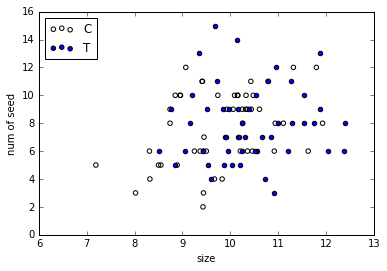

In [5]:
plt.scatter(data.x[data.f=='C'],data.y[data.f=='C'],label='C',facecolors='none')
plt.scatter(data.x[data.f=='T'],data.y[data.f=='T'],label='T')
plt.legend(loc='upper left')
plt.xlabel('size')
plt.ylabel('num of seed')

- 体サイズxが増加するにつれて種子数yが増えているようにみえるけどはっきりしない

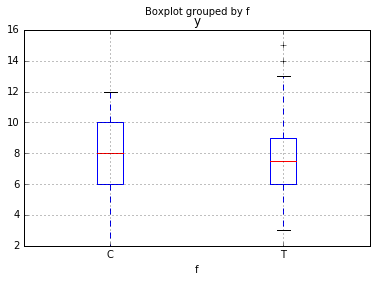

In [6]:
#箱ひげ図
data.boxplot('y',by='f')

- 肥料fの効果は全然内容にみえる。

### 線形予測子と線形リンク関数
個体ごとの平均種子数λi（種子数はy）が体サイズxや施肥f処理fに影響されるようなモデルを設計する。ここでは、xについて考える。λを以下のように仮定。ひとまず肥料の効果は無視できそうなので、無視する。
$$\lambda_{i}=exp(\beta_{1}+\beta_{2}x_{i})$$

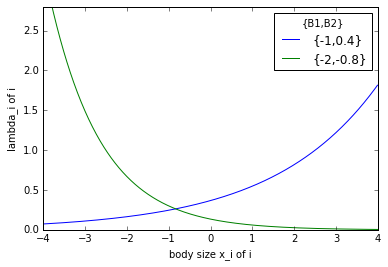

In [7]:
#仮定したモデルもける平均種子数のパラメータとの関係を図示する。
import numpy as np
x = np.arange(-4,4,0.01)

plt.plot(x,np.exp(-1+0.4*x),label='{-1,0.4}')
plt.plot(x,np.exp(-2-0.8*x),label='{-2,-0.8}')
plt.legend(title='{B1,B2}')
plt.xlabel('body size x_i of i')
plt.ylim([0,2.8])
plt.ylabel('lambda_i of i')
plt.show()

上述の$\lambda$の式の対数をとったものの、右辺は線形予測しと呼ばれる。
$$log\lambda_{i} = \beta_{1} + \beta_{2}x_{i}$$

また、$log\lambda_{i}=$（線形予測子）となっているが、このように($\lambda_{i}$の関数)=（線形予測子）となっている場合左辺を線形リンク関数と呼ばれる。この場合対数が使われているので、対数リンク関数と呼ばれる。ポアソン回帰の場合、大抵の場合は対数リンク関数をつかう。

### 当てはめと当てはまりの良さ
ポアソン回帰とは、観測データに対するポアソン分布を使った統計モデルの当てはめであり、この統計モデルの対数尤度が最大になるパラメータの推定値を決めることである。

In [8]:
#ポアソン回帰を実施
import statsmodels.api as sm

data.x_c = sm.add_constant(data.x) #コンスタント項を追加
model = sm.GLM(data.y,data.x_c,family=sm.families.Poisson())#familyはポアソン、リンク関数も指定できるけど省略している。
result = model.fit() #フィッティング
result.summary() #結果の表示

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Wed, 20 Jul 2016   Deviance:                       84.993
Time:                        22:50:02   Pearson chi2:                     83.8
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2917      0.364      3.552      0.000         0.579     2.005
x              0.0757      0.036      2.125      0.034         0.006     0.145
==============================================================================
"""

ポアソン回帰モデルによる予測

平均種子数$\lambda$に推定値を代入する。

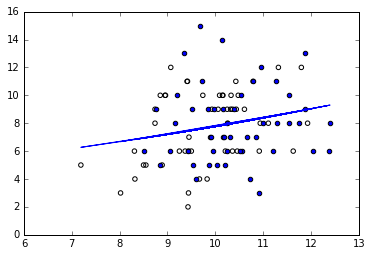

In [9]:
#観測値
plt.scatter(data.x[data.f=='C'],data.y[data.f=='C'],label='C',facecolors='none')
plt.scatter(data.x[data.f=='T'],data.y[data.f=='T'],label='T')
#予測値
x = np.arange(min(data.x),max(data.x),(max(data.x)-min(data.x))/100.)
plt.plot(data.x,result.predict(data.x_c))

説明変数が因子型（質的変数）の統計モデル

施肥効果$f_{i}$を説明変数として組み込んだモデルを検討する。

因子型の変数はダミー変数として扱う。

ここでは、サイズ$x_{i}$を無視して、以下のモデルを使う。

$$\lambda_{i} = exp(\beta_{1}+\beta_{3}d_{i})$$

In [10]:
#施肥の変数をダミー変数に変換する
data['f_int'] = (data['f'] == 'T').astype(int)
data.x_c = sm.add_constant(data['f_int'])

In [11]:
model = sm.GLM(data.y,data.x_c,family=sm.families.Poisson())

In [12]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -237.63
Date:                Wed, 20 Jul 2016   Deviance:                       89.475
Time:                        22:50:02   Pearson chi2:                     87.1
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.0516      0.051     40.463      0.000         1.952     2.151
f_int          0.0128      0.071      0.179      0.858        -0.127     0.153
==============================================================================
"""

- f_intの係数が0.0128のプラスなので、このモデルでは肥料をやると少しだけ平均種子が増えると予測している。
- $x_{i}$だけのモデルより対数尤度は低く、当てはまりは悪くなっている。

説明変数が数量型+因子型の統計モデル

$$log\lambda=\beta_{1}+\beta_{2}x_{i}+\beta_{3}d_{i}$$

In [13]:
data.x_c = sm.add_constant(data[['x','f_int']])
model = sm.GLM(data.y,data.x_c,family=sm.families.Poisson())

In [14]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Wed, 20 Jul 2016   Deviance:                       84.808
Time:                        22:50:03   Pearson chi2:                     83.8
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2631      0.370      3.417      0.001         0.539     1.988
x              0.0801      0.037      2.162      0.031         0.007     0.153
f_int         -0.0320      0.074     -0.430      0.667        -0.178     0.114
==============================================================================
"""

前の説では肥料の効果がプラスだったのに、このモデルではマイナスと推定されている。肥料の効果についてはいよいよわからなくなりました。

対数リンク関数のわかりやすさ：掛け算される効果

今回仮定した統計モデル
$$\lambda_i = exp(\beta_1 + \beta_2x_i + \beta_3d_i)\\d_iは質的変数$$

のログをとった時、左辺を対数リンク関数、右辺を線形予測子と呼ぶ
$$log\lambda_i=\beta_1 + \beta_2x_i+ \beta_3d_i$$

もし施肥処理がCならば
$$\lambda_i = exp(1.26+0.08x_i)$$

もし施肥処理がTならば
$$\lambda_i = exp(1.26+0.08x_i-0.032)$$

分解すると・・・
$$\lambda_i = exp(1.26)\times exp(0.08x_i)\times exp(-0.032)$$
$$=(定数)\times (サイズの効果)\times (施肥処理の効果)$$

平均λはサイズ、施肥処理それぞれの効果の積です。サイズが大きいほど施肥効果あり・なし間の乖離が大きくなる

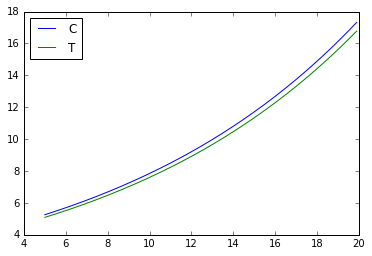

In [15]:
#説明変数がサイズと施肥処理の有無の場合の回帰モデルを図示する。
x = np.arange(5,20,0.1)
plt.plot(x,np.exp(1.26+0.08*x),label='C')
plt.plot(x,np.exp(1.26+0.08*x-0.032),label='T')
plt.legend(loc='upper left')
plt.show()

もし対数リンク関数を使わない場合はどうなるでしょうか。恒等リンク関数を使います。予測子は下式
$$\lambda_i = \beta_0 + \beta_1x_i + \beta_2d_i$$

In [31]:
import statsmodels
data.x_c = sm.add_constant(data[['x','f_int']])
model = sm.GLM(data.y,data.x_c,family=sm.families.Poisson(statsmodels.genmod.families.links.identity))

In [32]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.16
Date:                Wed, 20 Jul 2016   Deviance:                       84.538
Time:                        22:57:05   Pearson chi2:                     83.6
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2671      2.843      0.446      0.656        -4.306     6.840
x              0.6606      0.290      2.281      0.023         0.093     1.228
f_int         -0.2048      0.582     -0.352      0.725        -1.346     0.936
==============================================================================
"""

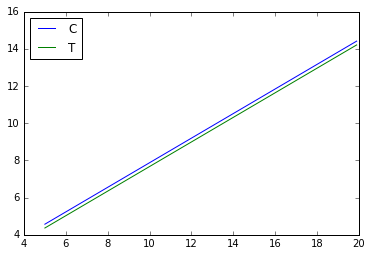

In [36]:
#恒等リンク関数を使った場合の回帰モデルを示す
x = np.arange(5,20,0.1)
plt.plot(x,1.2671+0.6606*x,label='C')
plt.plot(x,1.2671+0.6606*x-0.2048,label='T')
plt.legend(loc='upper left')
plt.show()

恒等リンク関数を使ったモデルの主張は、無処理における平均種子数が0.1個だろうが1000個だろうが、施肥処理をやったらどちらも0.205個減って、-0.1ことか999.8個になるんだということです。

どちらのリンク関数が妥当なもでるなのかは、当てはまりの良し悪しだけで決まる問題ではない。重要な点は数式が現象をどのように表現しているのかという点に注意しながら統計モデルを設計することである。